# Fun with embeddings!

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

### Load the embeddings from disk

In [2]:
#Use the output from the word2vec notebook
#embeddings = pd.DataFrame.from_csv('embeddings.csv')
#reverse_dictionary = np.array(list(embeddings.index))

# Use embeddings from polyglot 
# https://sites.google.com/site/rmyeid/projects/polyglot
reverse_dictionary, embeddings = pd.read_pickle('polyglot-en.pkl')
embeddings = normalize(embeddings)
reverse_dictionary = np.array(reverse_dictionary)
dictionary = dict(zip(reverse_dictionary, range(embeddings.shape[0])))
print(embeddings.shape)

(100004, 64)


### Find the most similar words

In [3]:
def most_similar(word, embeddings, reverse_dictionary, top_k=8):   
    valid_word = dictionary[word]
    similarity = cosine_similarity(embeddings, embeddings[valid_word, :].reshape(1, -1))
    nearest = (-similarity).argsort(axis=0)[1:top_k + 1].flatten()
    return reverse_dictionary[nearest]

In [4]:
most_similar("king", embeddings, reverse_dictionary)

array(['queen', 'prince', 'princess', 'emperor', 'King', 'ruler', 'father',
       'hero'],
      dtype='<U128')

### Analogies

Question task set downloaded from: http://download.tensorflow.org/data/questions-words.txt

In [5]:
questions = pd.read_table('questions-words.txt', comment=':', sep=' ', header=None)
print(questions.shape)

(19544, 4)


In [6]:
def evaluate_analogy(question):
    try:
        word1, word2, word3, word4 = question
        key1 = dictionary[word1.lower()]
        key2 = dictionary[word2.lower()]
        key3 = dictionary[word3.lower()]
        key4 = dictionary[word4.lower()]

        vec1 = embeddings[key1, :]
        vec2 = embeddings[key2, :]
        vec3 = embeddings[key3, :]
        vec4 = embeddings[key4, :]

        predict = vec2-vec1+vec3

        sim = np.matmul(predict, embeddings.T)
        nearest = np.argsort(-sim)[:4]

        return word4.lower() in reverse_dictionary[nearest]
    except:
        pass

In [7]:
results = [evaluate_analogy(questions.iloc[i]) for i in range(questions.shape[0])]

In [8]:
clean_results = [res for res in results if res is not None]
accuracy = np.mean(clean_results)
print(accuracy)

0.34814977009


## Visualization
### Embedding matrix

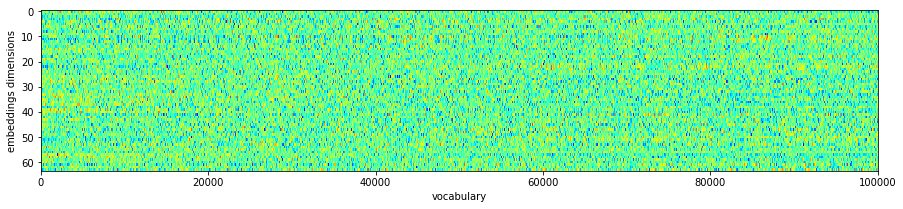

In [10]:
plt.figure(figsize=(15, 5))
plt.imshow(embeddings.T, aspect=300, cmap=cm.jet)
plt.xlabel("vocabulary")
plt.ylabel("embeddings dimensions")
plt.show()

### tSNE

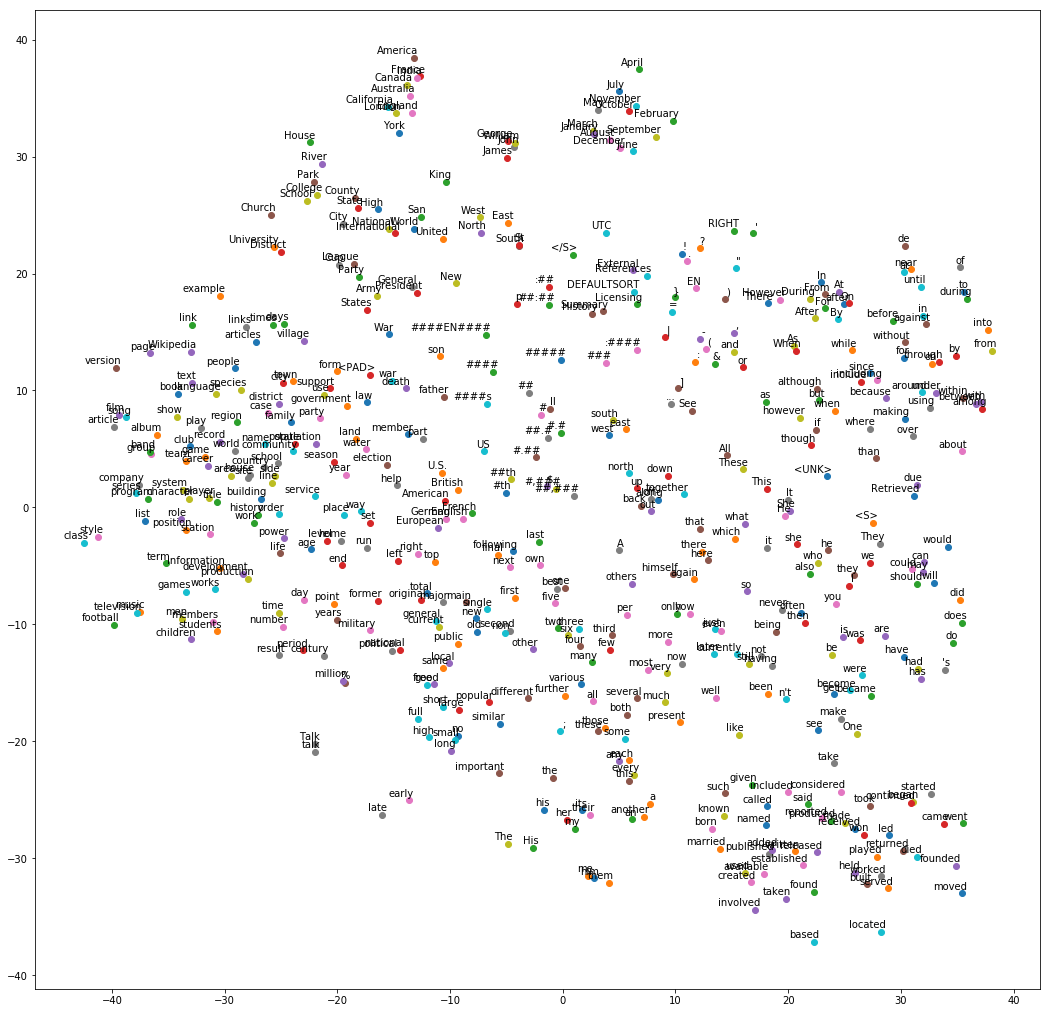

In [11]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500 # Plot only 500 words
low_dim_embs = tsne.fit_transform(np.array(embeddings)[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]

plt.figure(figsize=(18, 18))  # in inches
for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

#plt.savefig("tSNE.png")
plt.show()